# Imports

In [2]:
from cnmf import cNMF
from scipy.stats import zscore
from matplotlib.colors import rgb2hex
import scanpy as sc
import seaborn as sns
import os
from pathlib import Path
import pandas as pd
import anndata as ad
import numpy as np

# Custom Functions

In [3]:
def fpkm_to_tpm(self, fpkm):
    """
    Convert FPKM values to TPM.

    Parameters:
        fpkm (array-like): Array or list of FPKM values.

    Returns:
        np.ndarray: Array of TPM values.
    """
    fpkm = np.array(fpkm)
    return np.exp(np.log1p(fpkm) - np.log1p(np.sum(fpkm)) + np.log(1e6))

# Read Data

In [ ]:
try:
    _base_dir = Path(__file__).resolve().parent
except NameError:
    _base_dir = Path.cwd()

# The data folder is a subdirectory named 'EGAD00001001244' next to this script.
data_file = _base_dir / "data" / "files" / "tpm_counts.csv"

count_data = pd.read_csv(data_file,sep="\t",
    index_col=0,)

NameError: name 'Path' is not defined

In [ ]:
clinical_metadata_path = _base_dir / \
    / "data" / "files" / "data_clinical_patient.txt"

clinical_metadata = pd.read_csv(clinical_metadata_path, sep="\t")

clinical_metadata = clinical_metadata.iloc[4:, :]

# Subset clinical metadata with the samples from count_data
clinical_metadata_subset = clinical_metadata[
    clinical_metadata["#Patient Identifier"].isin(count_data.index)
].copy()

clinical_metadata_subset.rename(
    columns={
        "#Patient Identifier": "ID_Sample",
        "UICC Tumor Stage": "tnm_staging",
        "Sex": "sex",
        "Diagnosis Age": "age_at_sample",
        "Overall Survival (Months)": "time_since_t0_death",
        "Overall Survival Status": "status_os",
    },
    inplace=True,
)

clinical_metadata_subset["status_os"].replace(
    {"1:DECEASED": 1, "0:LIVING": 0}, inplace=True
)

# Add the staging (< III, LS, IV then ES)
clinical_metadata_subset["staging"] = clinical_metadata_subset["tnm_staging"].apply(
    lambda x: "ES" if x == "IV" else "LS" if x != "nan" else "LS"
)

try:
    clinical_metadata_subset.set_index("ID_Sample", inplace=True)
except Exception as e:
    print(f"Error setting index: {e}")

print(
    f"Number of samples per stage: {clinical_metadata_subset.staging.value_counts()}")

Number of samples per stage: staging
LS    72
ES     9
Name: count, dtype: int64


C:\Users\rafae\AppData\Local\Temp\ipykernel_26224\3453644255.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clinical_metadata_subset["status_os"].replace(
C:\Users\rafae\AppData\Local\Temp\ipykernel_26224\3453644255.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinical_metadata_subset[

In [6]:
count_data

,B2M,FTL,HLA-B,ANXA1,HLA-DRA,PFN1,CTSD,CD74,IGLL5,LYZ,...,CYP4F22,NDST4,CLEC12B,IL17C,AXDND1,SCN2A,CNTNAP5,RNF133,DNAH8,YAP1
sclc_ucologne_2015_S00022,2162.154403,2298.411925,1001.751408,23.633396,86.991391,678.728366,472.136116,27.912742,42.978858,28.775967,...,2.750689,8.490031,2.725959,2.992372,2.715768,3.514570,8.136591,2.696780,2.728837,3.277595
sclc_ucologne_2015_S00035,3160.088999,3745.273955,648.107862,102.795278,276.450852,615.955668,524.715629,50.000057,46.280251,84.170639,...,2.192853,8.469487,2.246005,3.080709,2.148493,7.893646,2.475983,2.318928,2.155952,3.605534
sclc_ucologne_2015_S00050,2052.014302,2118.938263,879.408577,36.147493,423.594166,532.336017,489.297038,109.557077,244.091360,212.364860,...,3.146193,6.516990,2.984626,3.215373,3.042088,4.725947,18.991687,3.011319,3.134531,3.915876
sclc_ucologne_2015_S00213,9640.167384,14605.657288,2289.823486,121.938662,2079.767782,884.827811,1074.222337,176.478753,5425.059394,2610.552043,...,2.681442,15.147577,2.421056,3.124963,2.386332,4.895384,2.558535,2.451218,2.389190,4.352976
sclc_ucologne_2015_S00356,5004.217605,4981.908336,835.222854,119.778900,983.900900,502.215145,514.830956,122.104755,1418.010653,499.754643,...,2.829266,3.128775,2.719074,3.650863,2.776094,10.940923,4.448620,3.396203,2.740640,5.575360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sclc_ucologne_2015_S02375,6812.104434,11667.759405,1509.701805,1282.925898,2003.241765,1048.792635,1064.024598,183.230711,318.635008,572.531677,...,2.093379,2.280902,2.106701,2.041678,2.030944,2.036819,3.085045,1.997111,2.072963,2.719448
sclc_ucologne_2015_S02376,8251.028221,3238.868715,3740.925445,83.274742,501.582874,1147.828117,389.587217,58.089660,541.181302,293.667019,...,2.179461,6.646879,2.105514,2.843782,2.154875,5.445269,6.453248,2.294543,2.117667,3.164042
sclc_ucologne_2015_S02378,9520.367291,6724.043881,2958.637473,209.366759,1717.925348,677.814857,1175.556034,183.766750,267.717238,523.855194,...,2.772599,2.877168,2.858701,3.147568,2.824992,2.806729,3.585936,2.965653,2.768039,6.153518
sclc_ucologne_2015_S02382,3779.392094,2525.732381,577.241843,161.040659,226.311589,307.053940,236.202220,49.486211,557.569124,478.677608,...,3.289202,3.953085,3.289202,6.149953,3.346079,4.930345,8.773256,3.703050,3.311947,7.840243


In [7]:
adata = ad.AnnData(count_data)

adata.obs = clinical_metadata_subset.copy()

adata.var = pd.DataFrame(count_data.columns)

adata.layers["tpm_counts"] = adata.X.copy()

adata.layers["log_tpm_counts"] = np.log1p(count_data.values).copy()

adata.layers["z_log_tpm_counts"] = zscore(
    adata.layers["log_tpm_counts"], axis=0).copy()


C:\Users\rafae\AppData\Local\Programs\Python\Python311\Lib\functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


In [8]:
adata.var.set_index(0, inplace=True)

In [ ]:
# Load genes 1300 discovery set
import openpyxl
final_genes = pd.read_excel(
    _base_dir / "data" / "files" / "1-s2.0-S1535610820306620-mmc2.xlsx",
    header=1,
)
final_genes = final_genes["Unnamed: 0"].tolist()
final_genes.append("YAP1")
# final_genes.extend(["ZEB1", "ZEB2", "SNAI1", "TWIST1"])
missing_genes = [gene for gene in final_genes if gene not in adata.var_names]
print("Missing genes:", missing_genes)

final_genes_filtered = [
    gene for gene in final_genes if gene in adata.var_names]
final_adata = adata[:, final_genes_filtered].copy()
final_adata.X = final_adata.layers["tpm_counts"].copy()

Missing genes: ['C11orf53', 'SGK223', 'LOC283710', 'FAM155A', 'BTBD11', 'CLECL1', 'FCGR1B']


# cNMF

In [10]:
counts_file_new = "./temp_counts_subtype_identification.txt"
pd.DataFrame(
	adata.X,
	index=adata.obs_names,
	columns=adata.var_names,
).to_csv(counts_file_new, sep="\t")

c:\Users\rafae\OneDrive\Documents\Projects\subtyping\subtyping\Lib\site-packages\cnmf\cnmf.py:616: UserWarning: 900 runs already appear completed. If this is unexpected, consider
            re-initializing the cnmf object with a different run name or output directory
  warnings.warn(message, UserWarning)


[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Worker 0]. Starting task 29.
[Worker 0]. Starting task 30.
[Worker 0]. Starting task 31.
[Worker 0]. Starting task 32.
[Worker 0]. Starting

c:\Users\rafae\OneDrive\Documents\Projects\subtyping\subtyping\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Selecting top 5000 genes for each subtype
['ASCL1', 'POU2F3', 'YAP1', 'NEUROD1']
['NEUROD1', 'YAP1', 'ASCL1', 'POU2F3']
['YAP1', 'ASCL1', 'NEUROD1', 'POU2F3']
['POU2F3', 'YAP1', 'NEUROD1', 'ASCL1']
Count of groups: nmf-group-de-novo
1    29
2    21
3    18
4    13
Name: count, dtype: int64
Saving top 5000 NMF genes to ./nmf_genes.csv


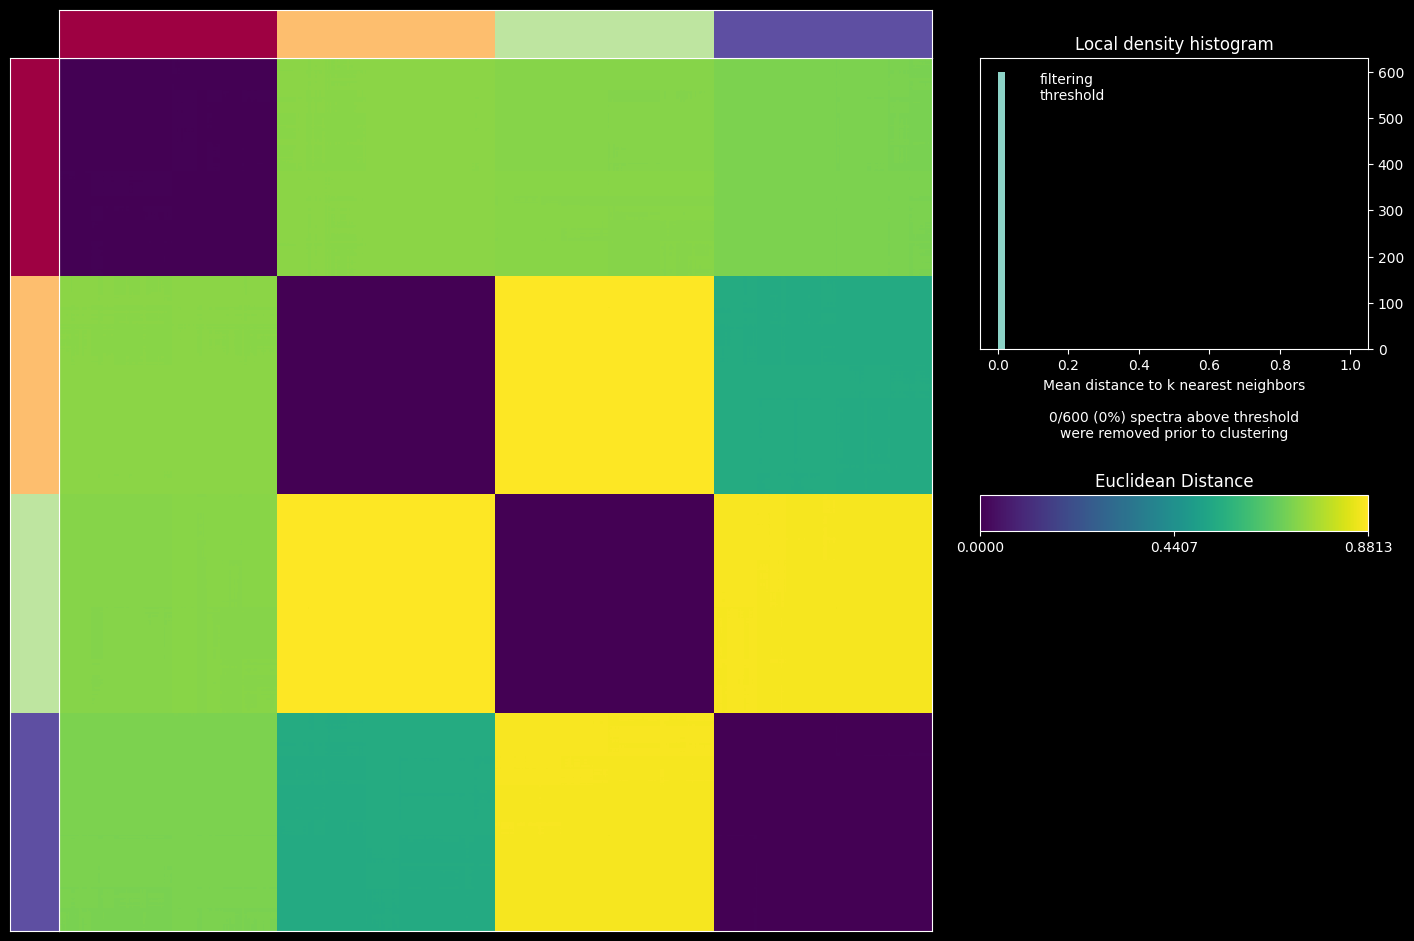

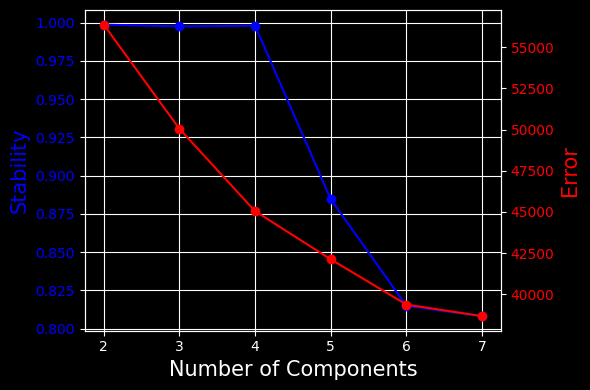

In [11]:

subtype_col_name="nmf-group-de-novo"
k: int = 4
density_threshold: float = 0.1
components: range = range(2, 8)
mandatory_genes: list = ["ASCL1", "NEUROD1", "POU2F3", "YAP1"]
n_iter: int = 150
total_workers: int = 1
num_highvar_genes: int = 2000
ntop_genes: int = 5000
data_save_path: str = "./"
layer = "tpm_counts"

cnmf_obj_new = cNMF(
	output_dir="./cnmf_results_selected_genes", name="nmf_selected_genes"
)

cnmf_obj_new.prepare(
	counts_fn=counts_file_new,
	tpm_fn=f"{_base_dir}/temp_counts_subtype_identification.txt",
	components=components,
	n_iter=n_iter,
	num_highvar_genes=num_highvar_genes,
)

cnmf_obj_new.factorize(worker_i=0, total_workers=total_workers)

cnmf_obj_new.combine()

cnmf_obj_new.consensus(
	k=k,
	density_threshold=density_threshold,
	show_clustering=True,
	close_clustergram_fig=False,
)

cnmf_obj_new.k_selection_plot()

usage_matrix_nmf_var, gep_scores_nmf_var, gep_tpm_nmf_var, topgenes_nmf_var = (
	cnmf_obj_new.load_results(K=k, density_threshold=density_threshold)
)

adata_nmf = adata.copy()
adata_nmf.obs = pd.merge(
	left=adata_nmf.obs,
	right=usage_matrix_nmf_var,
	how="left",
	left_index=True,
	right_index=True,
)
top_genes_nmf = []

print(f"Selecting top {ntop_genes} genes for each subtype")
for gep in gep_scores_nmf_var.columns:
	top_genes_nmf.append(
		list(
			gep_scores_nmf_var.sort_values(by=gep, ascending=False).index[
				:ntop_genes
			]
		)
	)

top_genes_nmf = pd.DataFrame(top_genes_nmf, index=gep_scores_nmf_var.columns).T

for col in top_genes_nmf.columns:
	print([g for g in top_genes_nmf[col] if g in mandatory_genes])

adata_nmf.obs[subtype_col_name] = usage_matrix_nmf_var.idxmax(
	axis=1
).astype(str)

print(
	f"Count of groups: {adata_nmf.obs[subtype_col_name].value_counts()}"
)

gene_df = pd.DataFrame({"gene": adata_nmf.var_names.tolist()})

print(
	f"Saving top {ntop_genes} NMF genes to {data_save_path + 'nmf_genes.csv'}"
)
gene_df.to_csv(data_save_path + "nmf_genes.csv")

usage_matrix_nmf_var = usage_matrix_nmf_var
gep_scores_nmf_var = gep_scores_nmf_var
gep_tpm_nmf_var = gep_tpm_nmf_var
topgenes_nmf_var = topgenes_nmf_var

In [20]:
adata_nmf.obs[["nmf-group-de-novo",1,2,3,4]]

,nmf-group-de-novo,1,2,3,4
ID_Sample,,,,,
sclc_ucologne_2015_S00022,2,0.472633,0.506275,0.006064,0.015028
sclc_ucologne_2015_S00035,1,0.836964,0.000000,0.106799,0.056237
sclc_ucologne_2015_S00050,2,0.174711,0.798140,0.027149,0.000000
sclc_ucologne_2015_S00213,3,0.417614,0.000000,0.539206,0.043180
sclc_ucologne_2015_S00356,1,0.427478,0.282972,0.198701,0.090849
...,...,...,...,...,...
sclc_ucologne_2015_S02375,4,0.034423,0.000000,0.384087,0.581490
sclc_ucologne_2015_S02376,1,0.656548,0.029480,0.260617,0.053356
sclc_ucologne_2015_S02378,3,0.175559,0.215421,0.337799,0.271221


In [13]:
key_markers_boxplot = pd.DataFrame(
	adata_nmf.layers["log_tpm_counts"],
	columns=adata_nmf.var_names,
	index=adata_nmf.obs_names,
)

In [14]:
key_markers_boxplot = key_markers_boxplot[["ASCL1", "NEUROD1", "POU2F3", "YAP1"]]

In [15]:
merged_data = key_markers_boxplot.merge(adata_nmf.obs[["nmf-group-de-novo"]], on="ID_Sample", how="inner")

In [16]:
import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams.update({"figure.figsize" : (12, 8),
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black"})

C:\Users\rafae\AppData\Local\Temp\ipykernel_26224\3511212893.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="nmf-group-de-novo", y=key_genes, data=merged_data, palette="Set2")


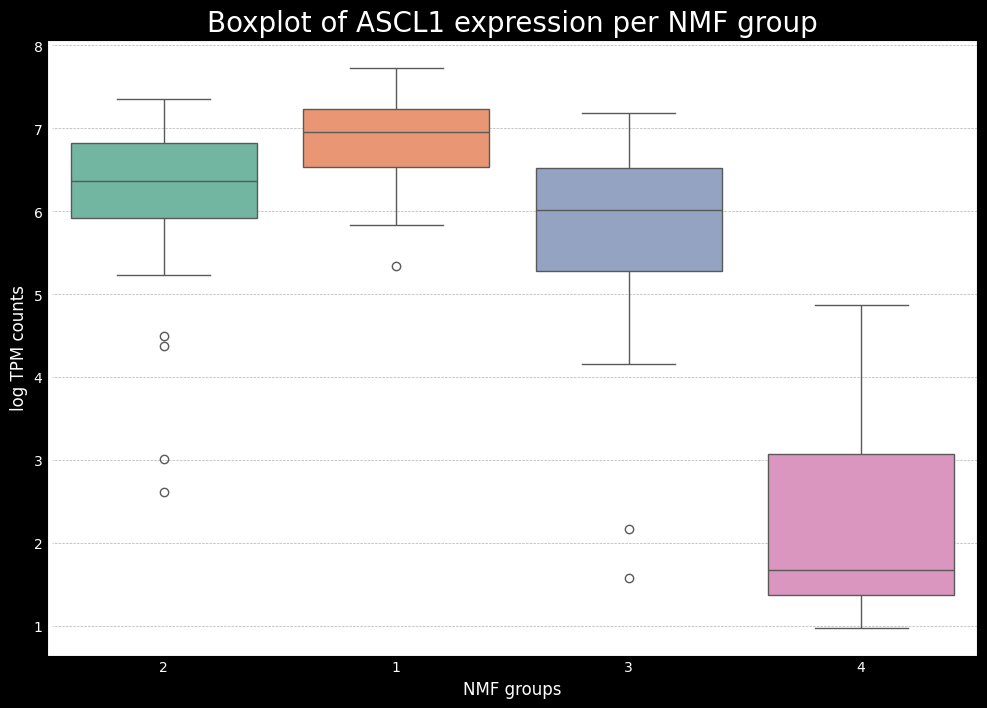

C:\Users\rafae\AppData\Local\Temp\ipykernel_26224\3511212893.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="nmf-group-de-novo", y=key_genes, data=merged_data, palette="Set2")


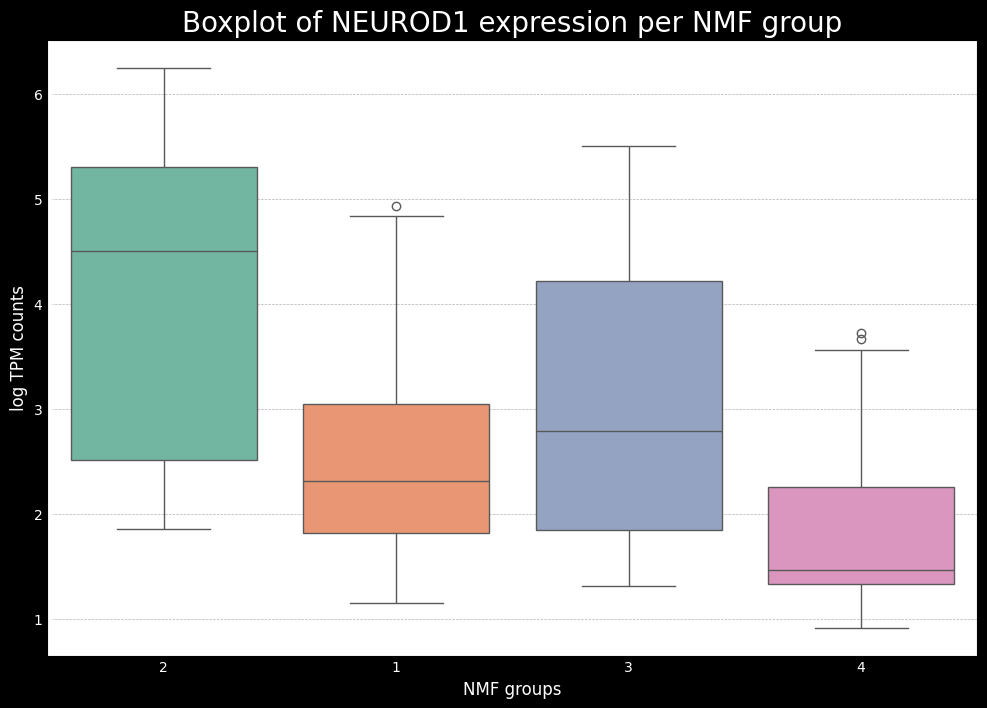

C:\Users\rafae\AppData\Local\Temp\ipykernel_26224\3511212893.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="nmf-group-de-novo", y=key_genes, data=merged_data, palette="Set2")


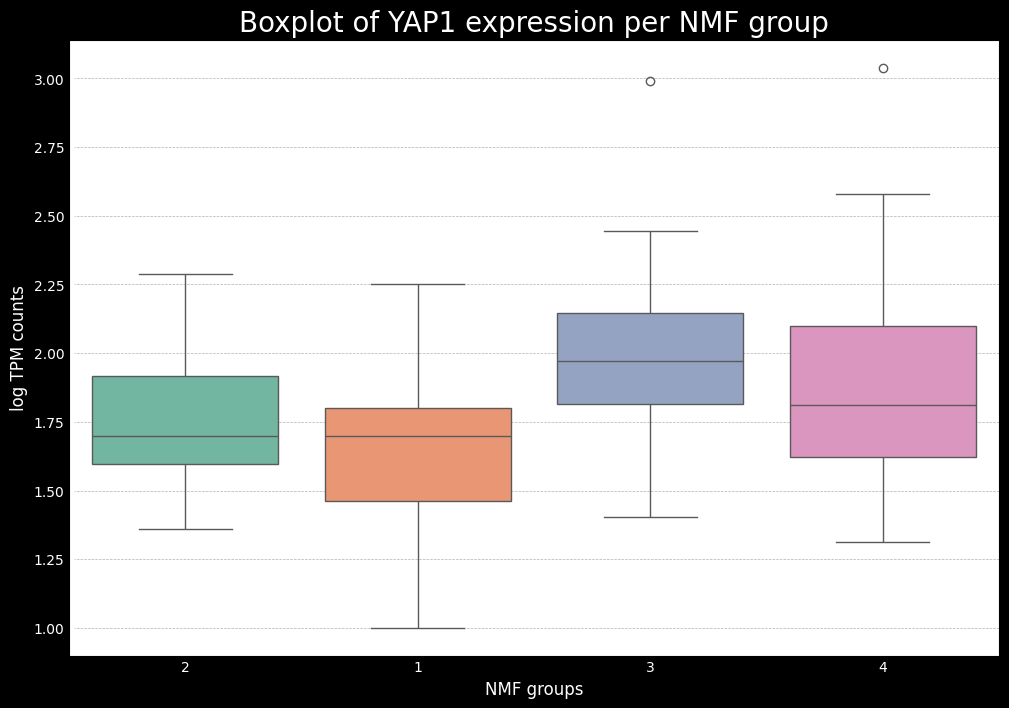

C:\Users\rafae\AppData\Local\Temp\ipykernel_26224\3511212893.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="nmf-group-de-novo", y=key_genes, data=merged_data, palette="Set2")


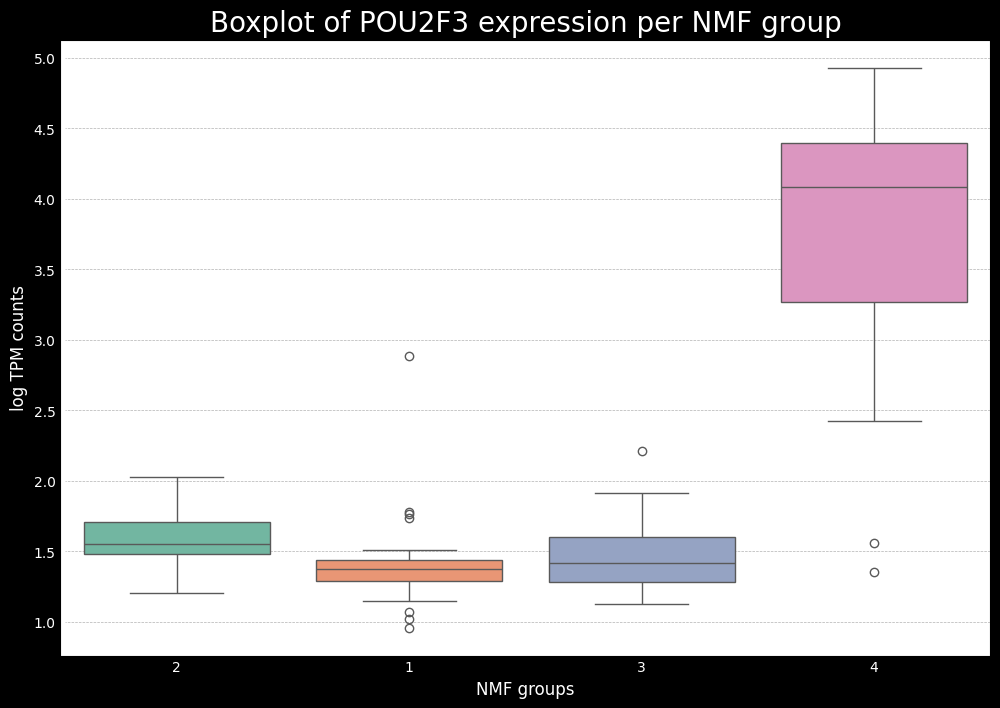

In [17]:
# Boxplot subtypes against key genes such as ASCL1, NEUROD1, YAP1, POU2F3 using log_tpm_counts

for key_genes in ["ASCL1", "NEUROD1", "YAP1", "POU2F3"]:
	ax = sns.boxplot(x="nmf-group-de-novo", y=key_genes, data=merged_data, palette="Set2")

	ax.set(xlabel="NMF groups", ylabel="log TPM counts")
	ax.set_title(f"Boxplot of {key_genes} expression per NMF group", fontsize=20)
	ax.set_ylabel("log TPM counts")
	ax.set_xlabel("NMF groups")	
	plt.show()
	plt.close()

                   NE_score  nonNE_score  T-eff_score  B/PC_score  APM_score  \
nmf-group-de-novo                                                              
1                      0.90        -0.55        -0.39       -0.23      -0.44   
2                      0.71        -0.47        -1.17       -1.08      -1.19   
3                     -0.37        -0.49         1.13        1.33       0.64   
4                     -1.24         1.50         0.44       -0.02       0.99   

                   Checkpt_score  
nmf-group-de-novo                 
1                          -0.66  
2                          -0.79  
3                           1.39  
4                           0.06  
                   NE_score  nonNE_score  T-eff_score  B/PC_score  APM_score  \
nmf-group-de-novo                                                              
1                      0.90        -0.55        -0.39       -0.23      -0.44   
2                      0.71        -0.47        -1.17       -1.08    

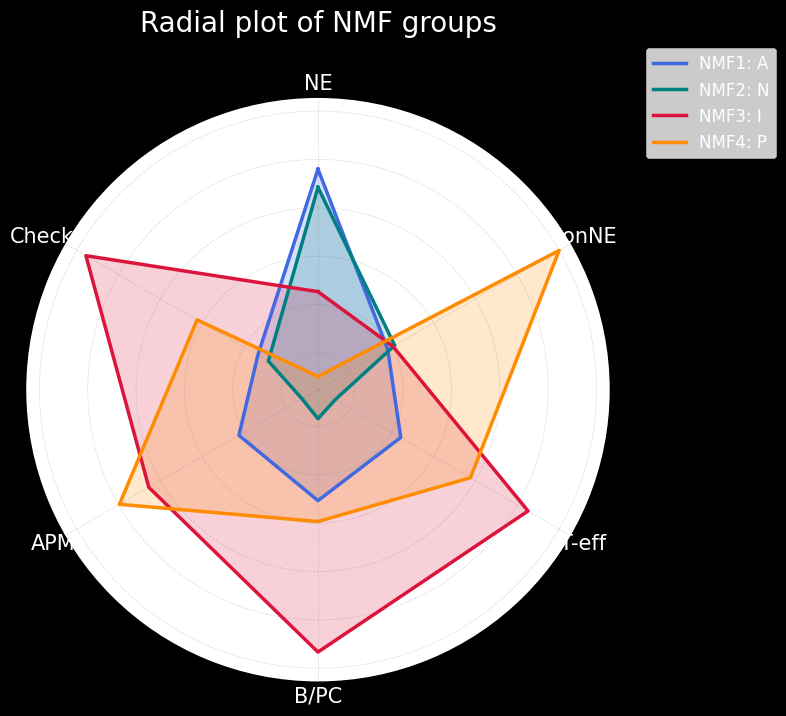

In [18]:

# %%
# Radial Plots ###########
adata_analysis_radial = adata_nmf.copy()
adata_analysis_radial.obs = adata_analysis_radial.obs[
    [
        1,
        2,
        3,
        4,
        "nmf-group-de-novo",
    ]
]

# Ensure we're working with raw counts
adata_analysis_radial.X = adata_analysis_radial.layers["log_tpm_counts"].copy()

# Normalize, log-transform, and scale the data
# sc.pp.normalize_total(adata_analysis_radial, target_sum=1e6)
# sc.pp.log1p(adata_analysis_radial)
sc.pp.scale(adata_analysis_radial)
# "EMT": ["ZEB1", "ZEB2", "SNAI1", "TWIST1"],
# Add gene categories
gene_categories = {
    "NE": ["CHGA", "DLL3", "NEUROD1", "INSM1", "ASCL1"],
    "nonNE": ["YAP1", "POU2F3", "MYC", "REST"],
    "T-eff": [
        "CD8A",
        "GZMA",
        "GZMB",
        "PRF1",
        "IFNG",
        "CXCL9",
        "CXCL10",
        "TBX21",
    ],
    "B/PC": ["CD79A", "MS4A1", "MZB1", "JCHAIN"],
    "APM": ["TAP1", "TAP2", "B2M", "HLA-A", "HLA-C"],
    "Checkpt": ["PDCD1", "CD274", "LAG3", "CTLA4", "BTLA", "TIGIT"],
}

# Compute scores for each category
for category, genes in gene_categories.items():
    sc.tl.score_genes(adata_analysis_radial, genes,
                      score_name=f"{category}_score")

# Calculate mean scores for each NMF group
nmf_scores = adata_analysis_radial.obs.groupby("nmf-group-de-novo").mean()

# Normalize scores (Z-score across subsets)
score_columns = [f"{cat}_score" for cat in gene_categories.keys()]
nmf_scores_norm = (
    nmf_scores[score_columns] - nmf_scores[score_columns].mean()
) / nmf_scores[score_columns].std()

# Define NMF labels
nmf_labels = {
    "1": "A",
    "2": "N",
    "3": "I",
    "4": "P",
}
print(nmf_scores_norm.round(2))
# Colors for each NMF group
colors = ["#8A7EB5", "#67C28E", "#E75480", "#FFA500"]
color_map = {
    "1": "#4169E1",  # A - RoyalBlue (cold)
    "2": "#008080",  # N - Teal (cold)
    "3": "#DC143C",  # I-nNE - Crimson (warm)
    "4": "#FF8C00",  # I-NE - DarkOrange (warm)
}


print(nmf_scores_norm.round(2))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection="polar")

# Prepare angles
categories = list(gene_categories.keys())
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the loop

# Plot each group
for nmf_group in sorted(nmf_scores_norm.index):
    data = nmf_scores_norm.loc[nmf_group, score_columns].to_frame().T
    values = data.values.flatten().tolist()
    values += values[:1]  # Complete the loop

    label = nmf_labels.get(nmf_group, nmf_group)
    color = color_map[nmf_group]

    ax.plot(
        angles,
        values,
        linewidth=2.5,
        linestyle="solid",
        label=f"NMF{nmf_group}: {label}",
        color=color,
    )
    ax.fill(angles, values, color=color, alpha=0.2)

# Format the plot
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=15)
ax.set_yticklabels([])  # Hide radial labels
ax.grid(True, color="grey", alpha=0.3)
ax.spines["polar"].set_visible(False)

ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=12)
ax.set_title("Radial plot of NMF groups", size=20, y=1.1)
plt.tight_layout()


plt.show()

